# RESTify Controlled Experiment Data Analysis

 > *Measuring the Software Engineering impact of a representative DSML toolchain.*

This Jupyter Notebook illustrates the design and results obtained throughout the McGill RESTify Controlled Experiment.
  * We summarize the experiment purpose, layout and step by step take you through the interpretation of all data collected.
      * For more information about the recruitment process, visit the [RESTify Experiment Recruitment Page](https://www.cs.mcgill.ca/~mschie3/recruitment/).
  * Starting point for all analyses in this document is data automatically mined from study participant submissions.
      * The data will be interpreted as is. However, it is possible to reproduce the data used by running our automated data extractor on the raw submission data. The (anonymized) raw data and analyzer source code are available at: [https://github.com/m5c/RestifyAnalyzer](https://github.com/m5c/RestifyAnalyzer)

## Abstract

Purpose of the RESTify (controlled) experiment a characterization of a DSML-centrist toolchain's effects on software engineering qualities. The remainder of this document is structured as follows:

 * [We describe an established refactoring task](#Task-And-Methodology) and [define metrics to express the fulfilment quality](#Metrics).
 * We then quantify and compare the quality of various task submissions, originating the outcome of several control groups. [The control groups were arranged](#Control-Groups) to pursue refactoring tasks using the DSML based toolchain and respectively manual code refactoring.
 * The main part is a statistical comparison of the measured submission qualities with respect to the applied refactoring quality. This is the core contribution of this notebook, for it allows a local and transparent reproduction of our results by the SE community.
 * The notebook concludes with an interpretation of the observed correlations.

The interest of this notebook centers on a fast and transparent replication of our statistical findings and claims. It extends the PDF article of our findings by the possibility to replicate our computations and verify a sane implementation of our metrics. For a contribution that focuses on a causal interpretation of these observations, we refer to a pending conference submission.

### Task and Methodologies

The aforementioned refactoring task is the conversion of legacy code to a RESTful service. Given the omnipresence of legacy systems and the continuously rising relevance of RESTful service based architectures, e.g. Microservice Architectures, this conversion can be seen a representative task with imminent industrial relevance.

#### Reference Context

We captured the refactoring challenge with two legacy systems, representing the e-commerce and gaming contexts frequently associated to RESTful services. Those are vanilla Java applications which express the core functionality of [a BookStore](https://github.com/m5c/BookStoreInternals/releases/tag/RestifyStudy) and [a Tic Tac Toe](https://github.com/m5c/XoxInternals/releases/tag/RestifyStudy) logic.

In technical detail, the refactoring task was the conversion of the provided legacy sources to a RESTful service, using the Spring Boot framework. Like all other details of the reference context, Spring was selected because of its widespread industrial acceptance.

#### Methodologies

We considered two orthogonal methodologies for the refactoring task.

  * The classic, code-oriented approach: A software developer manually modifies the project's legacy sources, for them to comply to a requested target behaviour. That is to say a developer loads the legacy project in their Integrated Developer Environment (IDE), integrates Spring Boot and exposes existing functionality over REST endpoints, using Spring's annotation syntax.
  * The DSML-oriented approach: Legacy sources are examined by a modeling tool and their existing functionality is visualized. The developer then uses a tailored DSML to design the desired interface layout and graphically maps the outcome to identified existing functionality. The modeling tool then generates the corresponding target sources.

 > TouchCORE is an academic tool that provides a proof-of-concept implementation for the DSML-oriented approach. The details of the process are [described in an earlier publication](https://www.cs.mcgill.ca/~mschie3/contributions/FIDDLR.pdf).

Manual code refactoring is the widespread standard methodology for the given task. However, lab internal experiments suggested that a DSML oriented approach can significantly outperform this manual methodology.
The RESTify controlled experiment was designed to gather the empirical data to test this hypothesis.

### Metrics

We considered two independent factors to measure goodness of a refactored submission: *Rapidness* of task completion and *Correctness* of the outcome. These are fair metrics, as the success of industrial projects is likewise held to these standards.

  * In the context of our study, we consider *Rapidness* a normalized derivative of the time to task submission. That is to say the fastest participant scored a value of ```1``` and the slowest participant obtained a value of ```0```. The remainder isscoring proportionally in the intermediate range ```[0-1]```.
  * We define *Correctness* of a solution by means of compliance to a predefined interface. Since the refactoring task mandates exposure of provided functionality through a defined REST interface, we can assess correctness [by automated, canonic tests of all individual interface endpoints](https://github.com/m5c/RestifyAnalyzer). The test passrate then provides a normalized notion for correctness, where ```1``` indicates full compliance to the expected interface and ```0``` complete missmatch.

Among other factors e.g. bound costs and high maintainability, software projects altogether aspire a maximization of *Rapidness* and *Correctness*. We therefore define the overall quality of a submission as weighted sum of these factors. Since the exact weighting may vary from project to project, we decided for equal shares, or ```0.5``` each.

The presented overall metric ranks submissions that were elicited fast and compliant to the target interface close to ```1```, while slow submission showcasing significant discrepancy to the interface specification score tend toward ```0```.

## Experiment Population

In this section we describe the efforts made to recruit a statistically sound population, including its partition into four representative control groups. We hired a total of 28 software developers with various backgrounds, to mitigate the impact of outliers and cover the diverse spectrum of real-world software developer profiles.

We start by a statistical analysis of the skill sets found in the overall population and then describe the methodology applied to obtain fair control groups.

 > Note that in reality these stages were interleaved, as we encountered participant fluctuation, resulting in recruitment iterations. The statistics shown in this document represent the final and stable population.

### Diversity

Recruitment included an auto-assessment of task related skills.

#### Self Assessment Form

Participants were asked to mark their proficiency on [a disseminated evaluation form](https://www.cs.mcgill.ca/~mschie3/recruitment/self-assessment.txt). For each of the 8 skill dimensions, we provided a textual metric that helped participants objectively quantify their skills on a scale of one to five.

Below example illustrates how we query proficiency for the singleton pattern:
```
How much do you know about the singleton pattern?
[ ] I don't know what it is.
[ ] I know what it is, but have never used it.
[ ] I have already used it in one of my projects.
[ ] I could verify a provided implementation.
[ ] I could implement it right away from scratch.
```

Participants were then asked to mark the most advanced option applicable.

#### Skill Analysis

We processed all participant self-declared skills and computed the resulting distribution.
The below cell replicates these computations and generates figures for the following statistics:

 * Sum of all declared skills, per participant (Mesh)
 * Proficiency in JAVA (Light Grey)
 * Proficiency with the Spring Framework (Mint)
 * Proficiency with the Build-System Maven (Light Blue)
 * Knowledge about the Modeling Tool TouchCORE (Deep Purple)
 * Proficiency with the UNIX/OS command line (Pink)
 * Knowledge about the REST networking paradigm (Red)
 * Knowledge about the Singleton pattern (Orange)
 * Knowledge about Reflection in programming languages (Dark Grey)

 > Note that the above colour scheme for individual skills is maintained for the remainder of this document.

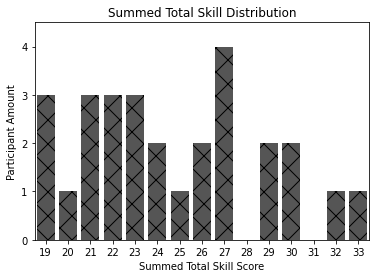

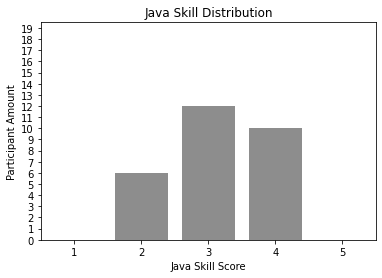

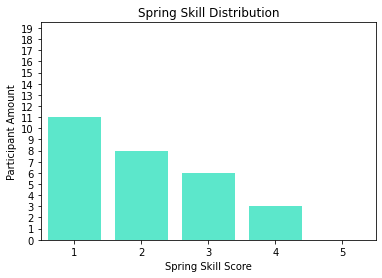

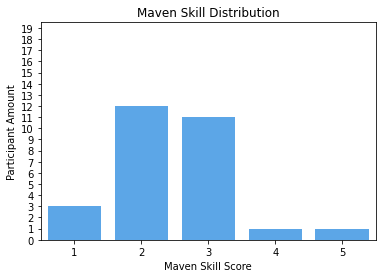

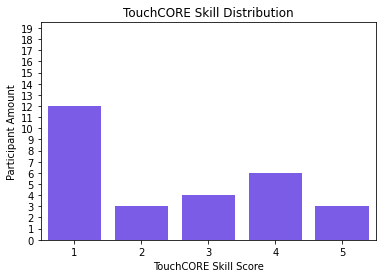

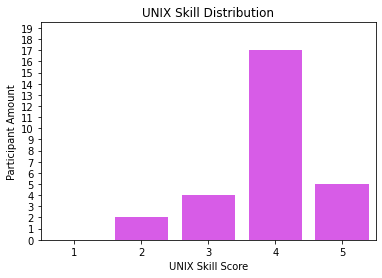

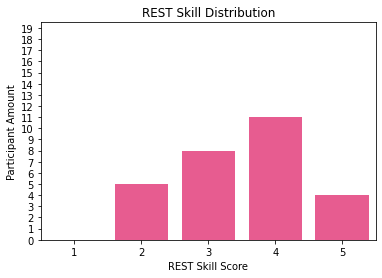

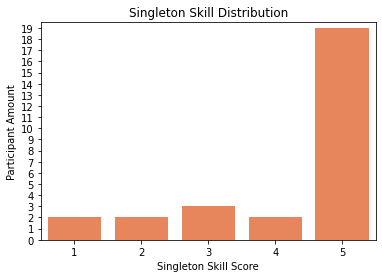

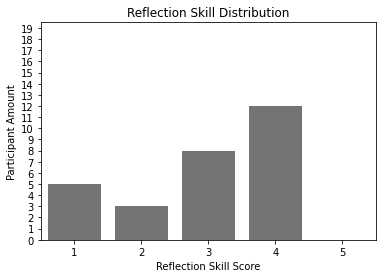

In [1]:
from jupyter_snippets.pseudo_cell_01_display_population_skill_stats import cell_01

cell_01()

#### Interpretation

We acknowledge the extracted distributions vary by skill. Yet we also observe a strong diversity in the population, which we deem a positive factor toward the expriment's robustness.
We also recognize that the profiles remain a self-declared assessment, and by nature is prone to subjective biases due to false estimations of the own skills.
In case of the participant who scored best, we also suspect at least one upfront dishonest declaration, where the associated participant performed extremely poor. We believe the participant had no interest in actual task solving and targeted uniquely the 100 Canadian Dollar gift card issued to participants as compensation. The participant is marked as outlier wherever applicable.

### Control groups

The purpose of the experiment was the comparison of orthogonal methodologies. For fairness, we could not simply ask every participant to first refactor using *Methodology A*, followed by refactoring the same application with *Methodology B*. We condered three potential learning effects that we wanted to eliminate:

  * Learning effect from the application context: The first and the second task should not concern the same codebase. We elicited two representative refactoring contexts:
    * The BookStore, a vanilla e-commerce application representing assortment, comments and stock information for a book vendor.
    * Xox, a vanilla board game application representing an action oriented implementation of Tic Tac Toe.
  * Potentially unfair advantage due to the application or methodology order:
    * Half the population should begin with *Application 1*, the other half should start with *Application 2*.
    * Half the population should begin with *Methodoloy A*, while the remainder should begin with *Methodology B*

To cover the above

The effective comparison of methodologies required a setup with four control groups.

TODO: explain that four groups needed. The exact layout in [...]()
Immediate challenge associated to subdivision: the groups must be fair in composition. We therefore needed a subdivision of participants into four comparable control groups, meaning groups of equal size, with comparable skill sets. The algorithm...

#### Heuristic Search for MiniMax


 We then [implemented and applied a heuristic algorithm](https://github.com/m5c/RecruitmentFormInterpreter) that divides the test population into groups of comparable skill vectors.

We ran a heuristic balancing algorithm to obtain control groups with high comparability in regards to their average score per skill. The algorithm searched for the participant distribution with lowest difference in skill differences per pair of team. Specifically, on every iteration we used the highest score difference on the same skill for any pair of control groups as quality metric. The original partitions were highly comparable: For every tested partition, we computed the highest difference for skill scores between any pair of teams. Goal was to minimize the value as far as possible, resulting in control groups that are highly comparable in any skill. We called this goal the search for the *MiniMax*. The value obtained through our heuristic for the originally recruited population was as low as ```0.6```, that means no matter what skill and pair of groups compared, the average difference in skill was guaranteed to be equal or lower to ```0.6```.

Droppers:

Unfortunately participants dropped out, even after having committed to a task. At this point we were able to hire replacements, however it was impossible to re-generate a fully optimized new control group repartition. At this point we had already received the first test results and since due to learning effects the study can not be run twice by the same participant, we had to reduce optimizations to a brute force testing of all permutations of dropped out participants and potential replacements. This adjustment had to be repeated three times, since participants kept dropping out, even after deadline extensions and reassured intent of participation.
Yet finally we were able to conclude the study with a population of 28 participants. Although comparability is not as optimal as in the original distribution, we were lucky enough to have ended up with somewhat comparable control groups.

The following interactive notebook cells provide evidence for the diversity of our test population, as well as pairwise comparability of resulting control groups.

The full boxplot of skill distributions per control group and resulting MiniMax (grid, printed in bold) is generated below:


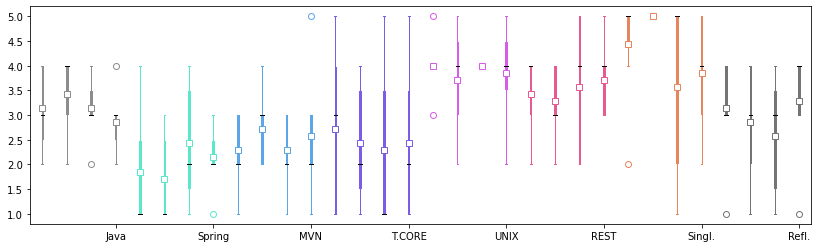

In [5]:
from jupyter_snippets.pseudo_cell_02_display_cgroups_skill_boxplot import cell_02

cell_02()

#### Asssessment of group comparability

TODO: bridge to numeric analysis of worst pairwise group diff:

In [6]:
from jupyter_snippets.pseudo_cell_04_compute_cgroup_skill_diffs import cell_04
from jupyter_snippets.pseudo_cell_03_merge_csvs import cell_03

cell_03()
cell_04()

<_io.TextIOWrapper name='source-csv-files/skills.csv' mode='r' encoding='utf-8'>
Control group comparability analysis. Listing of the greatest differences (average skill values) between any pairs of control groups:
Java	: 	AVG_MIN=2.9,	AVG_MAX=, 3.4,	MAX_AVG_DIFF=0.6
Spring	: 	AVG_MIN=1.7,	AVG_MAX=, 2.4,	MAX_AVG_DIFF=0.7
MVN	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
T.CORE	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
UNIX	: 	AVG_MIN=3.7,	AVG_MAX=, 4.0,	MAX_AVG_DIFF=0.3
REST	: 	AVG_MIN=3.3,	AVG_MAX=, 3.7,	MAX_AVG_DIFF=0.4
Singl.	: 	AVG_MIN=3.6,	AVG_MAX=, 5.0,	MAX_AVG_DIFF=1.4
Refl.	: 	AVG_MIN=2.6,	AVG_MAX=, 3.3,	MAX_AVG_DIFF=0.7
--------------
The worst difference in average skill values between two control groups in the given partition appears for:
	"Singleton", with a difference of 1.4




#### Group Tasks

Every participant was confronted with two subsequent engineering tasks. A sound statistical comparison of the two methodologies of interest (*Manual* VS *MDE*-driven) required a group design that effectively eliminates learning effects that stem from methodology or context order. The context here refers to the application to be refactored, which were an *e-commerce application* ([the bookstore](https://github.com/m5c/BookStoreInternals/tree/RestifyStudy)) and a *turn based game* ([tic tac toe](https://github.com/m5c/XoxInternals/tree/RestifyStudy)).

The below figure illustrates the resulting task orders for participants of the four control groups: *red*, *green*, *blue*, *yellow*

<div>
<img src="static-figures/salad.png" width="360"/>
</div>

TODO: Explain how to read this graphic on example.




FIRST: explain how time was measured, how correctenss was measured.

## Step 2 - Fusing the data

Throughout the experiment we measured different metrics per participant. Those are stored in separate CSV files. Some of them were auto-generated by additional scripts, some were created by hand.  
In a first step we are going to fuse all individual CSV files, using the *participant codename* as key. The codename consists of a colour and an animal.

 > We used a total of 4 control groups, *Red*, *Green*, *Blue*, *Yellow*, each starring 7 participants. This setup was chosen to reduce learning effects.
 
 The outcome of below cell is a new file: ```restify.csv```.  
 This file lists all data we ever process in the following, indexed by *participant codename*.

In [2]:
"""
This module updates the fused csv based on the current partial csv files found in
"source-csv-files", persists the outcome to disk and displays the content.
"""
from csv_tools import csv_merger

# Call the CSV merger, fuses all individual files based on participant group/codename as key.
csv_merger.build_merged_csv()

# Print the result
restify_csv = open("generated-csv-files/restify.csv", "r").read()
print(restify_csv)


codename,controlgroup,animal,javaskill,springskill,mavenskill,touchcoreskill,unixskill,restskill,singletonskill,reflectionskill,groupindex,firstapp,secondapp,firstmethodology,secondmethodology,tcinstructions,ideinstructions,xoxtime,bookstoretime,xoxverified,bsverified,tccomments,idecomments,assistedstatus,assistedsuccessrate,manualstatus,manualsuccessrate,GET/xox,POST/xox,GET/xox/id,DEL/xox/id,GET/xox/id/board,GET/xox/id/players,GET/xox/id/players/id/actions,POST/xox/id/players/id/actions/actionid,GET/bookstore/isbns,GET/bookstore/isbns/isbn,PUT/bookstore/isbns/isbn,GET/bookstore/stocklocations,GET/bookstore/stocklocations/stocklocation,GET/bookstore/stocklocations/stocklocation/isbns,POST/bookstore/stocklocations/stocklocation/isbns,GET/bookstore/isbns/isbn/comments,POST/bookstore/isbns/isbn/comments,DEL/bookstore/isbns/isbn/comments,POST/bookstore/isbns/isbn/comments/comment,DEL/bookstore/isbns/isbn/comments/comment
Red-Squid,red,squid,3,1,2,1,4,2,5,1,0,bookstore,xox,touchcore,manual

# Step 3 - Data Analysis

 * Overall population performance, all methodologies, all applications
    * Overall population performance, manual tasks (percentage)
    * Overall population performance, assisted tasks (percentage)

Here comes a great and intuitive to read text that explains how the unit-test plot is produced and how to read the results.

Key points:

  * Black horizontal bars: all tests failed because the submission did not compile or was not executable.
  * Black vertical bars: A test that failed for many participants.

    TODO: plot needs more labels.

In [3]:
from csv_tools import file_load_utils
from restify_mining.data_objects.assessed_participant import AssessedParticipant
from restify_mining.unit_test_miners.all_participants_all_tests_miner import AllParticipantsAllTestsMiner
from restify_mining.plotters.unit_test_plotter import mine_and_plot

# Load all participant objects (specifies skills, codename, control-group) from csv file
assessed_population: list[
    AssessedParticipant] = file_load_utils.load_all_assessed_participants()

# Create a 2D plot of all individual participant test results. On Y axis (vertical) all
# participants, on X axis (horizontal) all unit tests. Created image shows a black square for
# failed tests, coloured square (matching control group colour) for passed tests.
with_colours: bool = True
mine_and_plot(AllParticipantsAllTestsMiner(), with_colours, assessed_population)

ModuleNotFoundError: No module named 'restify_mining.plotters'

## Similar, a heatmap with the average test results per control group (TODO, split into applications)

Here comes a great and intuitive to read text that explains how the heatmap plot is produced and how to read the results.


In [ ]:
from csv_tools import file_load_utils
from restify_mining.data_objects.assessed_participant import AssessedParticipant
from restify_mining.plotters import unit_test_plotter

# Load all participant objects (specifies skills, codename, control-group) from csv file
assessed_population: list[
    AssessedParticipant] = file_load_utils.load_all_assessed_participants()

# Visualize test results in 2D plot and safe to disk
unit_test_plotter.plot_all_average_group_results(assessed_population)